# Requirements

In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of Spotify user reviews. The dataset contains two attributes:

+ **review** - A text column containing user feedback, opinions, and experiences with the Spotify application.
+ **sentiment** - A categorical column indicating whether the review has a positive or negative sentiment.

Your task involves training a model to predict the **sentiment** (either "positive" or "negative") based on the content of the **review**.

## The Spotify User Reviews Dataset

Load the dataset using the `datasets` library.

In [2]:
dataset = load_dataset('csv', data_files='spotify-user-reviews.csv')
dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
train_dataset = dataset['train']
test_dataset = dataset['test']


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [3]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# If your CSV column is named 'label', convert "positive"/"negative" to 1/0
def convert_labels(example):
    example["label"] = 1 if example["label"] == "positive" else 0
    return example

train_dataset = train_dataset.map(convert_labels)
test_dataset = test_dataset.map(convert_labels)

def tokenize_function(example):
    return tokenizer(
        example["review"], 
        padding="max_length", 
        truncation=True, 
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [4]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [5]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=50
)


Define the traning parameters using the `TrainingArguments` class.

In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', pos_label=1)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\velja_lo6afyb\AppData\Local\Temp\ipykernel_21844\4289966960.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Define the training using the `Trainer` class.

In [7]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.269200,0.255813,0.917500,0.941737,0.889890,0.915080
2,0.112100,0.315286,0.928500,0.921260,0.936937,0.929032
3,0.010400,0.354924,0.927500,0.926148,0.928929,0.927536


TrainOutput(global_step=3000, training_loss=0.16352504885196686, metrics={'train_runtime': 3453.0205, 'train_samples_per_second': 6.95, 'train_steps_per_second': 0.869, 'total_flos': 794804391936000.0, 'train_loss': 0.16352504885196686, 'epoch': 3.0})

Fine-tune (train) the pre-trained lanugage model.

In [8]:
metrics = trainer.evaluate(test_dataset)
print(metrics)


{'eval_loss': 0.3549235761165619, 'eval_accuracy': 0.9275, 'eval_precision': 0.9261477045908184, 'eval_recall': 0.928928928928929, 'eval_f1': 0.927536231884058, 'eval_runtime': 59.5986, 'eval_samples_per_second': 33.558, 'eval_steps_per_second': 4.195, 'epoch': 3.0}


Use the trained model to make predictions for the test set.

In [9]:
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
print(pred_labels[:10])

print(classification_report(
    predictions.label_ids,
    pred_labels,
    target_names=["negative","positive"]
))


[1 1 1 1 1 0 0 1 0 0]
              precision    recall  f1-score   support

    negative       0.93      0.93      0.93      1001
    positive       0.93      0.93      0.93       999

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [11]:
df = pd.read_csv("spotify-user-reviews.csv")
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = df_train["review"].values
y_train = df_train["label"].values
X_test = df_test["review"].values
y_test = df_test["label"].values

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000)),
    ("lr", LogisticRegression())
])

pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)

print(classification_report(y_test, pred, target_names=["negative", "positive"]))


              precision    recall  f1-score   support

    negative       0.85      0.88      0.87       990
    positive       0.88      0.85      0.86      1010

    accuracy                           0.86      2000
   macro avg       0.87      0.87      0.86      2000
weighted avg       0.87      0.86      0.86      2000



# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a machine learning pipeline to classify Spotify user reviews as positive or negative. Use TF-IDF vectorization to transform the review text into numerical features, and train a logistic regression model on the transformed data. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. To gain insights into the most influential words or phrases associated with positive and negative reviews, analyze the coefficients from the logistic regression model trained on the TF-IDF features. Present the top keywords for each sentiment in a table or a bar chart to provide a clear understanding of the terms driving user feedback.

In [12]:
feature_names = pipeline["tfidf"].get_feature_names_out()
coef = pipeline["lr"].coef_[0]
sorted_idx = np.argsort(coef)[::-1]

top_pos = [(feature_names[i], coef[i]) for i in sorted_idx[:10]]
top_neg = [(feature_names[i], coef[i]) for i in sorted_idx[-10:]]

print("Top Positive Words:")
for w, c in top_pos:
    print(w, c)

print("\nTop Negative Words:")
for w, c in top_neg:
    print(w, c)


Top Positive Words:
love 6.845007246182477
good 5.8719136079981595
best 5.772158471908068
great 5.67674259604472
amazing 4.1745210321808806
awesome 3.6726243588610368
nice 3.4862448320501507
excellent 3.2604066826139237
music 2.9921875391955366
enjoy 2.916059813014037

Top Negative Words:
only -2.3330651596945318
but -2.4795427469321987
doesn -2.563714878228397
why -2.6492309046850844
worst -2.848077005011994
update -2.899101424407134
ads -3.0167297972353264
annoying -3.0381195236102316
not -3.4869920218596695
fix -3.6477236792934944


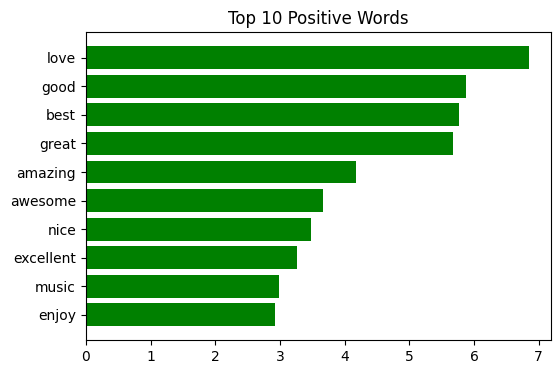

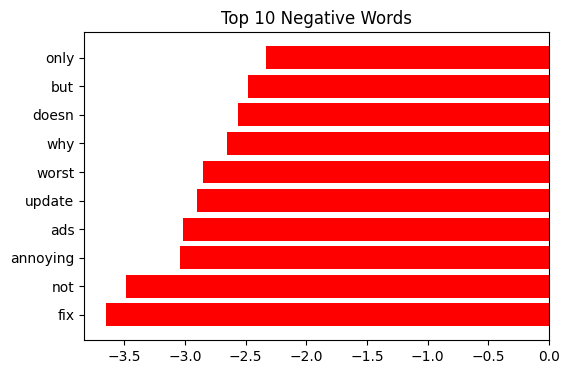

In [13]:
pos_words, pos_coefs = zip(*top_pos)
neg_words, neg_coefs = zip(*top_neg)

plt.figure(figsize=(6, 4))
plt.barh(pos_words, pos_coefs, color='green')
plt.title("Top 10 Positive Words")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(6, 4))
plt.barh(neg_words, neg_coefs, color='red')
plt.title("Top 10 Negative Words")
plt.gca().invert_yaxis()
plt.show()
